### Implements Layer-wise Relevance Propagation for the NIST AM dataset
#### LRP-epsilon

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import os
from skimage import io
import pandas as pd
import copy
import cv2
from PIL import Image as im
from torchvision.models import resnet18
import openpyxl
from matplotlib.legend_handler import HandlerTuple
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Include the neural network architecture and dataloader

In [2]:
class MeltPoolNetwork(nn.Module):
    """Neural Network for Melt Pool Shape Prediction"""
    
    def __init__(self, imageModel, num_classes=10, num_param=10):
        """
        Args:
            imageModel (A pytorch model): the CNN to use for melt pool image encoding
            num_classes (int): Number of different melt pool classes to predict
            num_param (int): Number of process parameters available
        """
        
        super().__init__()
        # The image encoder CNN
        self.ImageModel = imageModel
        
        # The process parameter encoder layers
        self.paramLayer1 = nn.Sequential(nn.Linear(num_param, 10), nn.Tanh())
        self.paramLayer2 = nn.Sequential(nn.Linear(10, 10), nn.Tanh())
        self.paramLayer3 = nn.Sequential(nn.Linear(10, 10), nn.Tanh())
        self.paramLayer4 = nn.Sequential(nn.Linear(10, 10), nn.Tanh())
        
        # prediction head layers
        self.prediction1 = nn.Sequential(nn.Linear(512+10, 100), nn.Tanh())
        self.prediction2 = nn.Linear(100, num_classes)
#         self.prediction = nn.Linear(512+10, num_classes)

        # Initialize Model Weights
        tanh_gain = torch.nn.init.calculate_gain('tanh', param=None)
        torch.nn.init.xavier_normal_(self.paramLayer1[0].weight, gain=tanh_gain)
        torch.nn.init.xavier_normal_(self.paramLayer2[0].weight, gain=tanh_gain)
        torch.nn.init.xavier_normal_(self.paramLayer3[0].weight, gain=tanh_gain)
        torch.nn.init.xavier_normal_(self.paramLayer4[0].weight, gain=tanh_gain)
        torch.nn.init.xavier_normal_(self.prediction1[0].weight, gain=tanh_gain)
        torch.nn.init.kaiming_normal_(self.prediction2.weight, a=0, mode='fan_in', nonlinearity='relu')

    def forward(self, img, pp):
        """
        Args:
            img (tensor): The melt pool image
            pp  (tensor): The process parameters
        """
        
        # Image CNN
        x = self.ImageModel(img)

        # PP NN
        y = self.paramLayer1(pp)
        y = self.paramLayer2(y)
        y = self.paramLayer3(y)
        y = self.paramLayer4(y)
        y = y.view(y.size(0), -1)

        # Prediction Head
#         y = torch.squeeze(y)  # remove any dimensions of 1
        z = torch.cat((x, y), dim=1)
        z = self.prediction1(z)
        z = self.prediction2(z)
#         z = self.prediction(z)
        return z

In [3]:
class MeltpoolDataset(Dataset):
    """Dataset for Meltpool Images and Process Parameters"""

    def __init__(self, xlsx_file, root_dir, transform=None):
        """
        Args:
            xlsx_file (string): file with process parameters and labels
            root_dir (string): image directory
            transform (callable, optional): transform(s) to apply
        """

        print('************** Loading Data **************')
        print(xlsx_file)
        
        # Load the excel file and separate into image file names, labels, and process parameters
        if xlsx_file.find('xlsx') >= 0:
            data_frame = pd.read_excel(xlsx_file, sheet_name='Sheet1', engine='openpyxl')
        elif xlsx_file.find('csv')>= 0:
            data_frame = pd.read_csv(xlsx_file)
        self.images = np.array(data_frame['image_name'])
        self.labels = np.array(data_frame['label'])
        self.process_parameters = np.array(data_frame[data_frame.columns[2:]])

        # We need to modify the image file names
        for ii in range(self.images.shape[0]):
            layer = self.images[ii][0:self.images[ii].find('_')]
            self.images[ii] = layer + '/' + self.images[ii]

        # Store some important information
        self.root_dir = root_dir
        self.transform = transform
        self.PIL_transform = transforms.ToPILImage()
        print('************ Finished Loading ************')

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load the image and convert to a PIL image
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = io.imread(img_name)
#         image = self.PIL_transform(image).convert('RGB')
        image = self.PIL_transform(image)
        
        # Apply transforms to the image
        if self.transform:
            image = self.transform(image)
        
        # Load the process parameters
        pp = self.process_parameters[idx, :]
        pp = pp.astype('float')
        
        # Load the label
        label = self.labels[idx]        

        return {'image': image, 'process_parameters': pp, 'label': label}

### LRP-Epsilon

In [4]:
class LRP(nn.Module):

    def __init__(self, model, eps=1.0e-9, gamma=0.1):
        super().__init__()
        self.model = model
        self.model.eval()

        self.eps = eps
        self.gamma = gamma
        self.layers = self.get_layers()

    def get_layers(self):

        # Builds list of all layers in the neural network
        # Works specifically for this CNN
        img_model_layers = nn.ModuleList()
        for module in self.model.ImageModel.children():
            if isinstance(module, nn.Sequential):
                for module2 in module.children():
                    # for module3 in module2.children():
                    #     if isinstance(module3, nn.Sequential):
                    #         for module4 in module3.children():
                    #             layers.append(module4)
                    #     else:
                    #         layers.append(module3)
                    img_model_layers.append(module2)
            else:
                img_model_layers.append(module)
        #         print(layers)

        param_layers = nn.ModuleList()
        final_layers = nn.ModuleList()
        for module in self.model.children():
            if not isinstance(module, torchvision.models.resnet.ResNet):
                if isinstance(module, nn.Sequential):
                    if module[0].in_features < 512:
                        for module2 in module.children():
                            param_layers.append(module2)
                    else:
                        for module2 in module.children():
                            final_layers.append(module2)
                else:
                    final_layers.append(module)

        layers = {"image": img_model_layers, "pp": param_layers, "final": final_layers}
        return layers

    def evaluate(self, sample):
        img = sample['image']
        x = img.to(device=device, dtype=torch.float)
        pp = sample['process_parameters']
        y = pp.to(device=device, dtype=torch.float)

        img_act = []
        pp_act = []
        final_act = []

        with torch.no_grad():
            img_act.append(torch.ones_like(x))
            for layer in self.layers["image"]:
                #                 print(layer)
                if isinstance(layer, nn.Linear):
                    x = x.squeeze(dim=2)
                    x = x.squeeze(dim=2)
                x = layer(x)
                # print(x.shape)
                img_act.append(x)

            pp_act.append(torch.ones_like(pp))
            for layer in self.layers["pp"]:
                y = layer(y)
                pp_act.append(y)

            # y = y.view(y.size(0), -1)
            x = torch.squeeze(x)
            y = torch.squeeze(y)
            z = torch.cat((x, y), dim=-1)
            for layer in self.layers["final"]:
                z = layer(z)
                final_act.append(z)

        img_act = img_act[::-1]  # reverse order
        img_act = [a.requires_grad_(True) for a in img_act]

        pp_act = pp_act[::-1]
        pp_act = [a.requires_grad_(True) for a in pp_act]

        final_act = final_act[::-1]
        final_act = [a.requires_grad_(True) for a in final_act]

        R = torch.softmax(final_act.pop(0), dim=-1)
        R_final = R

        R_final_list = []
        R_final_list.append(R)

        img_layers = self.layers['image']
        pp_layers = self.layers['pp']
        final_layers = self.layers['final']

        reverse_img_layers = img_layers[::-1]
        reverse_pp_layers = pp_layers[::-1]
        reverse_final_layers = final_layers[::-1]

        for layer in reverse_final_layers[:-1]:
            R_final = self.lrp_eval(layer, final_act.pop(0), R_final)
            R_final_list.append(R_final)

        act1 = img_act.pop(0)
        # act1 = torch.squeeze(act1, dim=0)
        act2 = pp_act.pop(0)
        # act2 = torch.squeeze(act2, dim=0)
        act = torch.cat((act1, act2), dim=1)

        R = self.lrp_eval(final_layers[0], act, R_final)
        R_final_list.append(R)

        R_img = R[0:512]
        R_img_list = []
        for layer in reverse_img_layers:
            R_img = self.lrp_eval(layer, img_act.pop(0), R_img)
            R_img_list.append(R_img)

        R_pp = R[512:]
        R_pp_list = []
        for layer in reverse_pp_layers:
            R_pp = self.lrp_eval(layer, pp_act.pop(0).to(device=device, dtype=torch.float), R_pp)
            R_pp_list.append(R_pp)

        return {"image": R_img_list, "pp": R_pp_list, "final": R_final_list}

    def lrp_eval(self, layer, a, R):
        if isinstance(layer, nn.Linear):
            a = a.squeeze()

        if isinstance(layer, nn.ReLU):
            return R

        a = a.data.requires_grad_(True)
        z = self.eps + layer.forward(a)
        s = (R / (z + 1e-9)).data  # 1e-9 to prevent divide by 0
        (z * s).sum().backward()
        c = a.grad
        R = a * c
        return R

### Load the data, neural network

In [5]:
BATCH_SIZE = 1 # Minibatch size to use
NUM_MELT_POOL_CLASSES = 24 # Number of different melt pool shape classes
NUM_PROCESS_PARAM = 9 # Number of process parameters
EPS = 0.1

# The base directory to images
# DATA_DIR = '../../../In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed PNG/'
DATA_DIR = '../../Melt Pool Camera Preprocessed PNG/'
# DATA_DIR = '../../RealTimeControl/Preprocessed Images/'

MODEL_NAME = 'testV30_1' # Name to save trained model

In [6]:
# neural_network_data/train_labels_pp.xlsx'
# meltpool_dataset_test = MeltpoolDataset(
#     'neural_network_data/test_labels_pp.csv', 
#     DATA_DIR,
#     transform=transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
# )
meltpool_dataset_test = MeltpoolDataset(
    'neural_network_data/dev_labels_pp_limited_scan_3d.csv', 
    DATA_DIR,
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
)

dataloader_test = DataLoader(meltpool_dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

************** Loading Data **************
neural_network_data/dev_labels_pp_limited_scan_3d.csv
************ Finished Loading ************


In [7]:
data_iter = iter(dataloader_test)

In [8]:
data = next(data_iter)
data

{'image': tensor([[[[0.0275, 0.0275, 0.0275,  ..., 0.0196, 0.0196, 0.0196],
           [0.0235, 0.0235, 0.0235,  ..., 0.0196, 0.0196, 0.0196],
           [0.0235, 0.0235, 0.0235,  ..., 0.0196, 0.0196, 0.0196],
           ...,
           [0.0314, 0.0275, 0.0275,  ..., 0.0235, 0.0275, 0.0275],
           [0.0314, 0.0275, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
           [0.0314, 0.0275, 0.0235,  ..., 0.0235, 0.0235, 0.0235]]]]),
 'process_parameters': tensor([[-0.6453,  0.5981,  0.0186, -0.6481,  0.0000, -0.5242,  0.0000,  1.0000,
           0.0000]], dtype=torch.float64),
 'label': tensor([20])}

In [9]:
MODEL_PATH = 'trained_models/' + MODEL_NAME + '.pth'

torch.cuda.empty_cache()

# Load neural network
ImgModel = resnet18()
ImgModel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
ImgModel.fc = nn.Linear(512, 512)
ImgModel.to(device)
model = MeltPoolNetwork(ImgModel, num_classes=NUM_MELT_POOL_CLASSES, num_param=NUM_PROCESS_PARAM).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval()

MeltPoolNetwork(
  (ImageModel): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

### Set up LRP and do one sample 

In [10]:
lrp_eps = LRP(model, eps=EPS)
lrp_eps

LRP(
  (model): MeltPoolNetwork(
    (ImageModel): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [11]:
sample = next(iter(dataloader_test))

R_dict = lrp_eps.evaluate(sample)
R_dict

{'image': [tensor([-0.0000e+00,  0.0000e+00,  3.0387e-05, -8.2731e-05, -0.0000e+00,
          -2.3504e-04,  6.2584e-04, -0.0000e+00, -0.0000e+00,  0.0000e+00,
          -2.3426e-04, -0.0000e+00,  0.0000e+00,  0.0000e+00, -7.7892e-03,
          -0.0000e+00,  0.0000e+00,  8.0966e-04, -0.0000e+00,  3.0349e-06,
          -1.6010e-04, -6.1479e-03,  0.0000e+00,  3.7785e-04, -0.0000e+00,
           2.8153e-05, -1.5292e-03, -6.1315e-05,  9.7899e-04, -7.3757e-03,
          -3.6224e-03, -1.0508e-03,  3.2394e-03, -0.0000e+00, -0.0000e+00,
           0.0000e+00,  0.0000e+00, -5.8511e-04, -0.0000e+00, -1.0569e-03,
           0.0000e+00,  7.6765e-04, -3.8838e-02, -0.0000e+00, -1.1759e-04,
          -0.0000e+00, -0.0000e+00, -3.2888e-03,  0.0000e+00, -2.3376e-02,
           1.1118e-07,  4.5598e-02,  7.6039e-03, -3.1727e-05,  0.0000e+00,
          -1.4530e-04,  0.0000e+00, -5.5907e-04,  0.0000e+00,  1.0620e-02,
           2.1376e-03,  1.4346e-03,  0.0000e+00,  0.0000e+00, -1.4215e-02,
          -5.052

## Analyze the LRP Results 

In [12]:
sample = next(iter(dataloader_test))

img = sample['image'].numpy().squeeze()
img = np.transpose(img, axes=[1,2,0])
pp = sample['process_parameters'].numpy()
label = sample['label'].item()
R_img_list = R_dict["image"]
R_img = R_img_list[-1].cpu().detach().numpy().squeeze()
R_img = np.transpose(R_img, axes=[1,2,0])

R_pp_list = R_dict["pp"]
R_pp = R_pp_list[-1]

images = sample['image']
process_parameters = sample['process_parameters']
images = images.to(device=device, dtype=torch.float)
process_parameters = process_parameters.to(device=device, dtype=torch.float)
with torch.set_grad_enabled(False):
    outputs = model(images, process_parameters)
    _, preds = torch.max(outputs, 1)
        
fig, axs = plt.subplot_mosaic([['left', 'right'],['bottom', 'bottom']])
axs['left'].imshow(img)
# axs['left'].title.set_text("GT: " + str(label) + ", Pred: " + str(preds.item()))
axs['left'].title.set_text("Original Image")
axs['left'].set_xticks([])
axs['left'].set_yticks([])
axs['left'].set_xticklabels([])
axs['left'].set_yticklabels([])

heatmap = axs['right'].imshow(R_img)
cbar = fig.colorbar(heatmap, ax=axs['right'])
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()
axs['right'].title.set_text('Image Relevance')
axs['right'].set_xticks([])
axs['right'].set_yticks([])
axs['right'].set_xticklabels([])
axs['right'].set_yticklabels([])

axs['bottom'].scatter(np.arange(9), R_pp.cpu().detach().numpy(), color="blue", marker="d")
axs['bottom'].set_ylabel("Relevance",fontsize=14)
# axs['bottom'].set_ylabel("Relevance",color="blue",fontsize=14)
axs['bottom'].axhline(0, linestyle='dashed')

axs['bottom'].title.set_text('Parameter Relevance')
pp_labels = ('Power','Speed','x_dir', 'y_dir','Acceleration','Energy Density','Heating',
             'Turning', 'Residual Heat')
axs['bottom'].set_xticks(np.arange(9))
axs['bottom'].set_xticklabels(pp_labels, rotation=80, fontdict={'fontsize': 12})
fig.tight_layout()
plt.show()

ValueError: axes don't match array

#### Save LRP outputs to file --- FIXME

In [ ]:
# LRP-Epsilon
counter = 0
for sample in dataloader:
    if np.mod(counter, 500) == 0:
        print(counter, '/', len(dataloader))
    counter += 1
    
    pp = sample['process_parameters']
    
    img_name = sample['img_name'][0]
    idx = img_name.find('Base')
    if idx == -1:
        idx = img_name.find('MPA')
    img_name1 = img_name[idx:]
    if os.path.exists('./analysis/lrp_epsilon_combined_sigmoid_side_by_side/' + img_name1):
        continue
        
    R_dict =lrp_combined.evaluate(sample)

    img = sample['image']
    img = img.numpy().squeeze()
    img = np.uint8(255*img)
    img = np.stack((img,img,img), 2)
    
    label = sample['label'].item()

    R_img_list = R_dict["image"]
    R_img = R_img_list[-1]

    R_pp_list = R_dict["pp"]
    R_pp = R_pp_list[-1]

    # Original Image
    img_name = sample['img_name'][0]
    orig_img = cv2.imread(img_name)
    # Get image name
    idx = img_name.find('Base')
    if idx == -1:
        idx = img_name.find('MPA')
    img_name1 = img_name[idx:]

    images = sample['image']
    process_parameters = sample['process_parameters']
    images = images.to(device=device, dtype=torch.float)
    process_parameters = process_parameters.to(device=device, dtype=torch.float)
    with torch.set_grad_enabled(False):
        outputs = model(images, process_parameters)
        _, preds = torch.max(outputs, 1)
    
    fig, axs = plt.subplot_mosaic([['left', 'right'],['bottom', 'bottom']])
    axs['left'].matshow(img)
    axs['left'].title.set_text("GT: " + str(label) + ", Pred: " + str(preds.item()))
    axs['left'].set_xticks([])
    axs['left'].set_yticks([])
    axs['left'].set_xticklabels([])
    axs['left'].set_yticklabels([])

    heatmap = axs['right'].matshow(R_img.cpu().detach().numpy().squeeze())
    cbar = fig.colorbar(heatmap, ax=axs['right'])
    axs['right'].title.set_text('Image Relevance')
    axs['right'].set_xticks([])
    axs['right'].set_yticks([])
    axs['right'].set_xticklabels([])
    axs['right'].set_yticklabels([])

    axs['bottom'].bar(np.arange(12), R_pp.cpu().detach().numpy(), color="blue")
    axs['bottom'].set_ylabel("Relevance",color="blue",fontsize=14)
    
    ax2 = axs['bottom'].twinx()
    ax2.scatter(np.arange(12), pp, c="orange", marker="d")
    ax2.set_yticks([-1.0, -0.5, 0, 0.5, 1])
    ax2.set_ylabel("PP Value",color="orange",fontsize=14)
    axs['bottom'].title.set_text('Parameter Relevance')
    pp_labels = ('P','V','a', 'Energy Density','isAccel','isSpeeding','isSlowing',
             'isTurning', 'isHeating','isCooling','closeness1', 'closeness2')
    axs['bottom'].set_xticks(np.arange(12))
    axs['bottom'].set_xticklabels(pp_labels, rotation=90)
    plt.tight_layout()
    fig.savefig('./analysis/lrp_epsilon_combined_sigmoid_side_by_side/' + img_name1)
    if (label != preds.item()):
        fig.savefig('./analysis/lrp_epsilon_combined_sigmoid_side_by_side_incorrect/' + img_name1)
    plt.close(fig)

### Analyze the Process Parameters 

In [12]:
# LRP-Epsilon
pp_array = np.zeros((NUM_MELT_POOL_CLASSES, NUM_PROCESS_PARAM))
ed_list = [list() for i in range(NUM_MELT_POOL_CLASSES)]
pp_counts = np.zeros(NUM_MELT_POOL_CLASSES)
importance_array = np.zeros((NUM_MELT_POOL_CLASSES,NUM_PROCESS_PARAM))

for sample in tqdm(dataloader_test): 
        
    R_dict =lrp_eps.evaluate(sample)
    
    R_img_list = R_dict["image"]
    R_img = R_img_list[-1]

    R_pp_list = R_dict["pp"]
    R_pp = R_pp_list[-1]
    
#     if np.max(R_pp.detach().cpu().numpy()) > 1:
#         img_name = sample['img_name'][0]
#         print(R_pp)
    
    pp = sample['process_parameters'][0]

    
    images = sample['image']
    process_parameters = sample['process_parameters']
    images = images.to(device=device, dtype=torch.float)
    process_parameters = process_parameters.to(device=device, dtype=torch.float)
    with torch.set_grad_enabled(False):
        outputs = model(images, process_parameters)
        _, preds = torch.max(outputs, 1)
        
        pp_array[preds,:] += pp.numpy()
        pp_counts[preds] += 1
        importance_array[preds,:] += R_pp.cpu().numpy()
        ed_list[preds].append(pp.numpy()[5])

100%|███████████████████████████████████████████████████████████████████████████| 103081/103081 [22:46<00:00, 75.46it/s]


In [13]:
# Calculate the average within each melt pool class
pp_avg = np.zeros((NUM_MELT_POOL_CLASSES, NUM_PROCESS_PARAM))
importance_avg = np.zeros((NUM_MELT_POOL_CLASSES, NUM_PROCESS_PARAM))
for ii in range(NUM_MELT_POOL_CLASSES):
    pp_avg[ii,:] = pp_array[ii,:] / pp_counts[ii]
    importance_avg[ii, :] = importance_array[ii,:] / pp_counts[ii]

In [14]:
# Save the results
np.save('LRP_results/pp_avg_test_V30_eps_' + str(EPS), pp_avg)
np.save('LRP_results/importance_avg_test_V30_eps_' + str(EPS), importance_avg)

In [15]:
# Load the results
pp_avg = np.load('LRP_results/pp_avg_test_V30_eps_' + str(EPS) + '.npy')
importance_avg = np.load('LRP_results/importance_avg_test_V30_eps_' + str(EPS) + '.npy')

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of ticklabels (6).

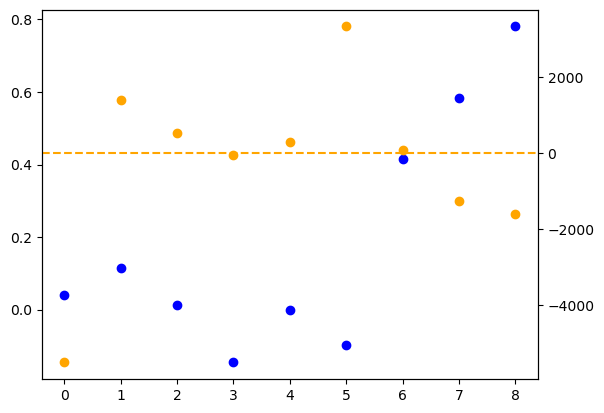

In [16]:
# Plot the results
for ii in range(NUM_MELT_POOL_CLASSES):    
    fig, ax = plt.subplots()
    ax.scatter(range(NUM_PROCESS_PARAM), pp_avg[ii, :], color="blue")
    ax2 = ax.twinx()
    
    ax2.scatter(range(NUM_PROCESS_PARAM), importance_avg[ii,:], color="orange")
    ax2.axhline(0, linestyle='dashed', color="orange")
    ax.set_xticks(np.arange(NUM_PROCESS_PARAM))
    pp_labels = ('Power','Speed','Acceleration','Energy Density','Heating', 'Residual Heat')
    ax.set_xticklabels(pp_labels, rotation=90)
    ax.set_ylabel("Avg. Process Parameter Values",color="blue",fontsize=14)
    ax.set_ylim([-1, 1])
    ax2.set_ylabel("Avg. Relevance",color="orange",fontsize=14)
    plt.title('Melt Pool Class ' + str(ii+1))
    plt.tight_layout()
    plt.savefig('Plots/LRP_plots/V30_eps_' + str(EPS) + '/PP_relevance_class'+str(ii+1)+'_LowRes', dpi=150)
#     plt.savefig('Plots/LRP_plots/eps_' + str(EPS) + '/PP_relevance_class'+str(ii+1), dpi=800)
    plt.show()